In [55]:
import pandas as pd
import numpy as np
import requests
import unicodedata
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('earthquake.csv')

In [8]:
data.shape

(24007, 17)

In [9]:
data = pd.read_csv('earthquake.csv')

In [10]:
# función para sacar el año de la fecha
def get_year(date):
    return(int(date[:4]))

data['year'] = data['date'].map(get_year)
data.head()

,id,date,time,lat,long,country,city,area,direction,dist,depth,xm,md,richter,mw,ms,mb,year
0,2.000000e+13,2003.05.20,12:17:44 AM,39.04,40.38,turkey,bingol,baliklicay,west,0.1,10.0,4.1,4.1,0.0,NaN,0.0,0.0,2003
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,turkey,kocaeli,bayraktar_izmit,west,0.1,5.2,4.0,3.8,4.0,NaN,0.0,0.0,2007
2,1.980000e+13,1978.05.07,12:41:37 AM,38.58,27.61,turkey,manisa,hamzabeyli,south_west,0.1,0.0,3.7,0.0,0.0,NaN,0.0,3.7,1978
3,2.000000e+13,1997.03.22,12:31:45 AM,39.47,36.44,turkey,sivas,kahvepinar_sarkisla,south_west,0.1,10.0,3.5,3.5,0.0,NaN,0.0,0.0,1997
4,2.000000e+13,2000.04.02,12:57:38 AM,40.80,30.24,turkey,sakarya,meseli_serdivan,south_west,0.1,7.0,4.3,4.3,0.0,NaN,0.0,0.0,2000


In [11]:
# eliminamos registros anteriores a 1964
# eliminamos registros de terremotos con índice 0 en la Escala de Richter
data = data.query('year >= 2004 & richter != 0')
# nos quedamos con las columnas que nos interesan
data = data[['id', 'date', 'time', 'lat', 'long', 'city', 'area', 'richter', 'year']]
data.shape

(6213, 9)

In [12]:
null_cols = data.isnull().sum()
null_cols

id            0
date          0
time          0
lat           0
long          0
city       2947
area       2358
richter       0
year          0
dtype: int64

In [13]:
def get_city(location):
    key = open(".env", "r").read()
    response = requests.get("https://geocodeapi.p.rapidapi.com/GetNearestCities?latitude={}&longitude={}&range=0".format(location[0], location[1]),
        headers={
        "X-RapidAPI-Host": "geocodeapi.p.rapidapi.com",
        "X-RapidAPI-Key": key
        }
    )
    res = response.json()
    return unicodedata.normalize('NFKD',res[0]['City']).encode('ASCII', 'ignore').decode('utf-8').lower()

In [14]:
get_city((0,0))

'takoradi'

In [15]:
data['coords'] = list(zip(data.lat, data.long))
data.head()

,id,date,time,lat,long,city,area,richter,year,coords
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,kocaeli,bayraktar_izmit,4.0,2007,"(40.79, 30.09)"
6,2.010000e+13,2012.06.24,12:07:22 AM,38.75,43.61,van,ilikaynak,4.5,2012,"(38.75, 43.61)"
9,2.010000e+13,2011.10.28,12:47:56 AM,38.76,43.54,van,degirmenozu,4.2,2011,"(38.76, 43.54)"
10,2.010000e+13,2013.05.01,12:47:56 AM,37.31,37.11,kahramanmaras,ordekdede_pazarcik,3.5,2013,"(37.31, 37.11)"
15,2.010000e+13,2011.05.22,12:49:49 AM,39.13,29.04,kutahya,kapikaya_simav,3.9,2011,"(39.13, 29.04)"


In [17]:
# lo siguiente era para obtener las ciudades de todos los terremotos pero, al hacer muchas peticiones, tardaba demasiado
'''
res = []

for row in data.index: 
    res.append(get_city(data.loc[row, 'coords']))
print(res)
'''

['kosekoy', 'ozalp', 'van', 'pazarck', 'simav', 'erzin', 'corum', 'bigadic', 'biga', 'karakocan', 'ayvack', 'doganyol', 'menderes', 'niksar', 'hns', 'van', 'bigadic', 'ayvack', 'gozyeri', 'simav', 'ercis', 'ercis', 'pazarck', 'gevas', 'orhaneli', 'balkesir', 'ercis', 'andrn', 'pazarck', 'andrn', 'altpnar', 'ozalp', 'saphane', 'silopi', 'sapanca', 'andrn', 'simav', 'kastamonu', 'savastepe', 'sarksla', 'yatagan', 'yatagan', 'balkesir', 'bolu', 'simav', 'akhisar', 'ercis', 'ayvack', 'can', 'sanlurfa', 'samsat', 'karlova', 'cihanbeyli', 'van', 'adyaman', 'aliaga', 'ercis', 'gevas', 'doganyol', 'sapanca', 'cungus', 'doganyol', 'ilgaz', 'varto', 'mutki', 'kas', 'van', 'bodrum', 'milas', 'akhisar', 'simav', 'van', 'kozan', 'karakocan', 'yunak', 'simav', 'pazarck', 'akyaz', 'yenicaga', 'amasya', 'ercis', 'golmarmara', 'milas', 'simav', 'refahiye', 'ercis', 'ozalp', 'van', 'pazarck', 'sivrice', 'honaz', 'dursunlu', 'hizan', 'ercis', 'ercis', 'golmarmara', 'palu', 'simav', 'ercis', 'van', 'iskil

In [25]:
data['city2'] = res
data.head()

,id,date,time,lat,long,city,area,richter,year,coords,city2
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,kocaeli,bayraktar_izmit,4.0,2007,"(40.79, 30.09)",kosekoy
6,2.010000e+13,2012.06.24,12:07:22 AM,38.75,43.61,van,ilikaynak,4.5,2012,"(38.75, 43.61)",ozalp
9,2.010000e+13,2011.10.28,12:47:56 AM,38.76,43.54,van,degirmenozu,4.2,2011,"(38.76, 43.54)",van
10,2.010000e+13,2013.05.01,12:47:56 AM,37.31,37.11,kahramanmaras,ordekdede_pazarcik,3.5,2013,"(37.31, 37.11)",pazarck
15,2.010000e+13,2011.05.22,12:49:49 AM,39.13,29.04,kutahya,kapikaya_simav,3.9,2011,"(39.13, 29.04)",simav


In [22]:
data.to_csv('data_cities.csv')

In [16]:
data = pd.read_csv('data_cities.csv')

In [82]:
data = data.query('year >= 2004')
data['year'].value_counts()

2011    804
2012    667
2013    613
2017    571
2016    569
2014    563
2015    534
2007    306
2010    303
2008    303
2005    301
2009    280
2006    169
2004    153
Name: year, dtype: int64

In [83]:
# clasificar Qs según los meses del año
bins = [0, 4, 5, 7]
data['richter_bins'] = pd.cut(data['richter'], bins)

In [85]:
# analysis
date_richter = pd.pivot_table(data, values = 'date', index = 'year', columns = 'richter_bins', aggfunc = len, fill_value = 0)

In [86]:
date_richter.head()

richter_bins,"(0, 4]","(4, 5]","(5, 7]"
year,,,
2004,83,62,8
2005,169,115,17
2006,100,65,4
2007,206,90,10
2008,214,82,7


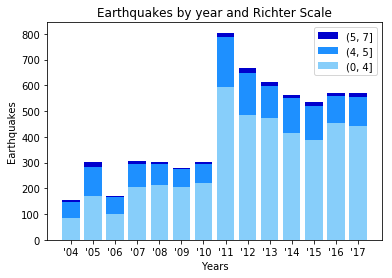

In [134]:
N = len(date_richter)
x = list(date_richter.iloc[:, 2])
y = list(date_richter.iloc[:, 1])
z = list(date_richter.iloc[:, 0])
ind = np.arange(N)

p1 = plt.bar(ind, z, color = '#87cefa')
p2 = plt.bar(ind, y, bottom = z, color = '#1e90ff')
p3 = plt.bar(ind, x, bottom = ([sum(x) for x in zip(y, z)]), color = ('#0000cd'))

plt.ylabel('Earthquakes')
plt.xlabel('Years')
plt.title('Earthquakes by year and Richter Scale')
plt.xticks(ind, ['\'' + (str(x)[2:]) for x in list(date_richter.index)])
plt.legend((p3[0], p2[0], p1[0]), ('(5, 7]', '(4, 5]', '(0, 4]'))
plt.show()

In [164]:
top15cities = data['city2'].value_counts()[:15]
top15cities.reset_index()
top15cities.columns = ['city', 'earthquakes']
print(list(top15cities.index))
top15cities.columns
print(type(top15cities))

['sitia', 'ercis', 'van', 'archangelos', 'ierapetra', 'mournies', 'moires', 'simav', 'myrina', 'bodrum', 'mytilene', 'ayvack', 'ozalp', 'datca', 'paphos']
<class 'pandas.core.series.Series'>


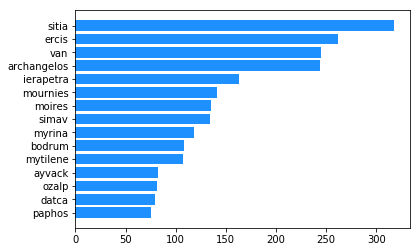

In [170]:
height = list(top15cities)[::-1]
bars = list(top15cities.index)[::-1]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height, color = '#1e90ff')
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
plt.show()